## I. Package Imports ##

`Cell 01`

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as mpgs
from skimage.feature import hog
%matplotlib inline

import glob
import time
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from scipy.ndimage.measurements import label

from collections import deque

## II. Helper Functions ##

`Cell 02`

In [2]:
# Helper function to merge two lists of images, alternating between both lists
# This is required to display images for comparison

def merge_lists(imgarray1, imgarray2, count=None):
    
    if count is None:
        count = len(imgarray1)
    output = []
    for i in range(count):
        output.append(imgarray1[i])
        output.append(imgarray2[i])
    
    return output

`Cell 03`

In [3]:
# Helper function to display images
# The input array should contain an even number of images

def display_images(imgarray, titles=None, cmap=None):
    ncols = 2
    nrows = int(len(imgarray)/2)
    figsize = (ncols*9, nrows*7)
        
    fig = plt.figure(figsize=figsize)
    gs = mpgs.GridSpec(nrows, ncols)
    gs.update(bottom=0.375)
    for i in range(len(imgarray)):
        sub = plt.subplot(gs[i])
        if titles is not None:
            sub.set_title(titles[i], size=17)
        sub.imshow(imgarray[i], cmap=cmap)

`Cell 04`

In [4]:
# Helper function to change the color space of an image

def convert_color(img, conv='RGB2YUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


`Cell 05`

In [5]:
# Define a function to return HOG features and visualization

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

`Cell 06`

In [6]:
# Define a function to compute binned color features  

def bin_spatial(img, size=(32, 32)):
    
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))

`Cell 07`

In [7]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!

def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    
    return hist_features

`Cell 08`

In [8]:
# Define a function to extract features from a list of images

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for image in imgs:
        
        file_features = []
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features

`Cell 09`

In [9]:
# Define a function to draw bounding boxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

## III. Data Loading ##

`Cell 10`

In [10]:
# Load file names

base_path = 'D:\Projects\data\\'
cars_filenames = glob.glob(base_path+"vehicles\**\*.png")
noncars_filesnames = glob.glob(base_path+"non-vehicles\**\*.png")

# Save as RGB to maintain a uniform pipeline
cars = [cv2.cvtColor(cv2.imread(cf), cv2.COLOR_BGR2RGB) for cf in cars_filenames]
noncars = [cv2.cvtColor(cv2.imread(ncf), cv2.COLOR_BGR2RGB) for ncf in noncars_filesnames]

`Cell 11`

In [11]:
# Display number of car and non-car images
print("{} car images\n{} non-car images".format(len(cars), len(noncars)))

8792 car images
8968 non-car images


`Cell 12`

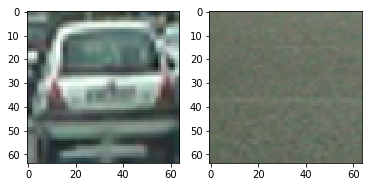

In [12]:
# Display a random car and non-car image

plt.subplot(121)
plt.imshow(cars[np.random.randint(0, len(cars))])

plt.subplot(122)
plt.imshow(noncars[np.random.randint(0, len(noncars))])

## IV. Feature Extraction & Training ##

`Cell 13`

In [13]:
# Extract features from both image sets; car and non-car

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
hist_bins = 32
spatial_size = (32, 32)

t=time.time()
car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size, 
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel
                               )
noncar_features = extract_features(noncars, color_space=colorspace, spatial_size=spatial_size, 
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel
                               )
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print(np.array(car_features).shape)

53.46 Seconds to extract HOG features...
(8792, 4932)


`Cell 14`

In [14]:
# Merge and scale the data sets

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations, 8 pixels per cell and 2 cells per block
Feature vector length: 4932


`Cell 15`

In [91]:
# Grid Search for SVC

svc_grid = SVC()
t=time.time()
parameters = {'kernel':['rbf', 'linear'],'C':[1, 10], 'tol':[0.001, 0.01, 0.05], }
clf = GridSearchCV(svc_grid, parameters)
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

6143.64 Seconds to train SVC...


`Cell 16`

In [110]:
print("The best score is {:.4f} with :\n".format(clf.best_score_))
print(clf.best_estimator_)


The best score is 0.9932 with :

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.05, verbose=False)


`Cell 17`

In [94]:
# Training for SVC with optimum hyper-parameters

svc = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.05, verbose=False)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

163.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9935


`Cell 18`

In [ ]:
# Grid Search for Linear SVC

svc = LinearSVC()
t=time.time()
parameters = {'dual':[False],'C':[1, 10], 'loss':['squared_hinge', 'hinge']}
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

`Cell 19`

In [77]:
#Training for Linear SVC

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Linear SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

19.25 Seconds to train Linear SVC...
Test Accuracy of SVC =  0.9806


** Save the GridSearch and the best trained Model **

`Cell 20`

In [113]:
pickle.dump(clf, open("gridsearch_svc.p", 'wb'))
pickle.dump(svc, open("model.p", "wb"))

** Load the best trained Model **

`Cell 21`

In [15]:
svc = pickle.load(open("model.p", "rb"))
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9994


`Cell 22`

In [16]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [0. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
For these 10 labels:  [0. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
0.12309 Seconds to predict 10 labels with SVC


## V. Testing the Model ##

`Cell 23`

In [17]:
filenames = glob.glob( "test_images\*.jpg")
test_images = np.array([mpimg.imread(name) for name in filenames])


`Cell 24`

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, ystart, ystop, scale, svc, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    all_boxes = []
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch. Only channel 0 is required in this model.
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            temp = np.hstack((spatial_features, hist_features, hog_feat1))
            magna = temp.reshape(1, -1)


            # Scale features and make a prediction
            test_features = X_scaler.transform(magna)   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xstart + xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                draw_points = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                all_boxes.append(draw_points)
    return all_boxes

`Cell 25`

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

`Cell 26`

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

`Cell 27`

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

`Cell 28`

In [22]:
def single_pipeline(img):
    
    copyimg = np.copy(img)
    
    xstart = 400
    ystart = 400
    ystop = 650
    scale = 1.5

    bboxes = find_cars(copyimg, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap, bboxes)
    #heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(copyimg, labels)
    
    return final_img

`Cell 29`

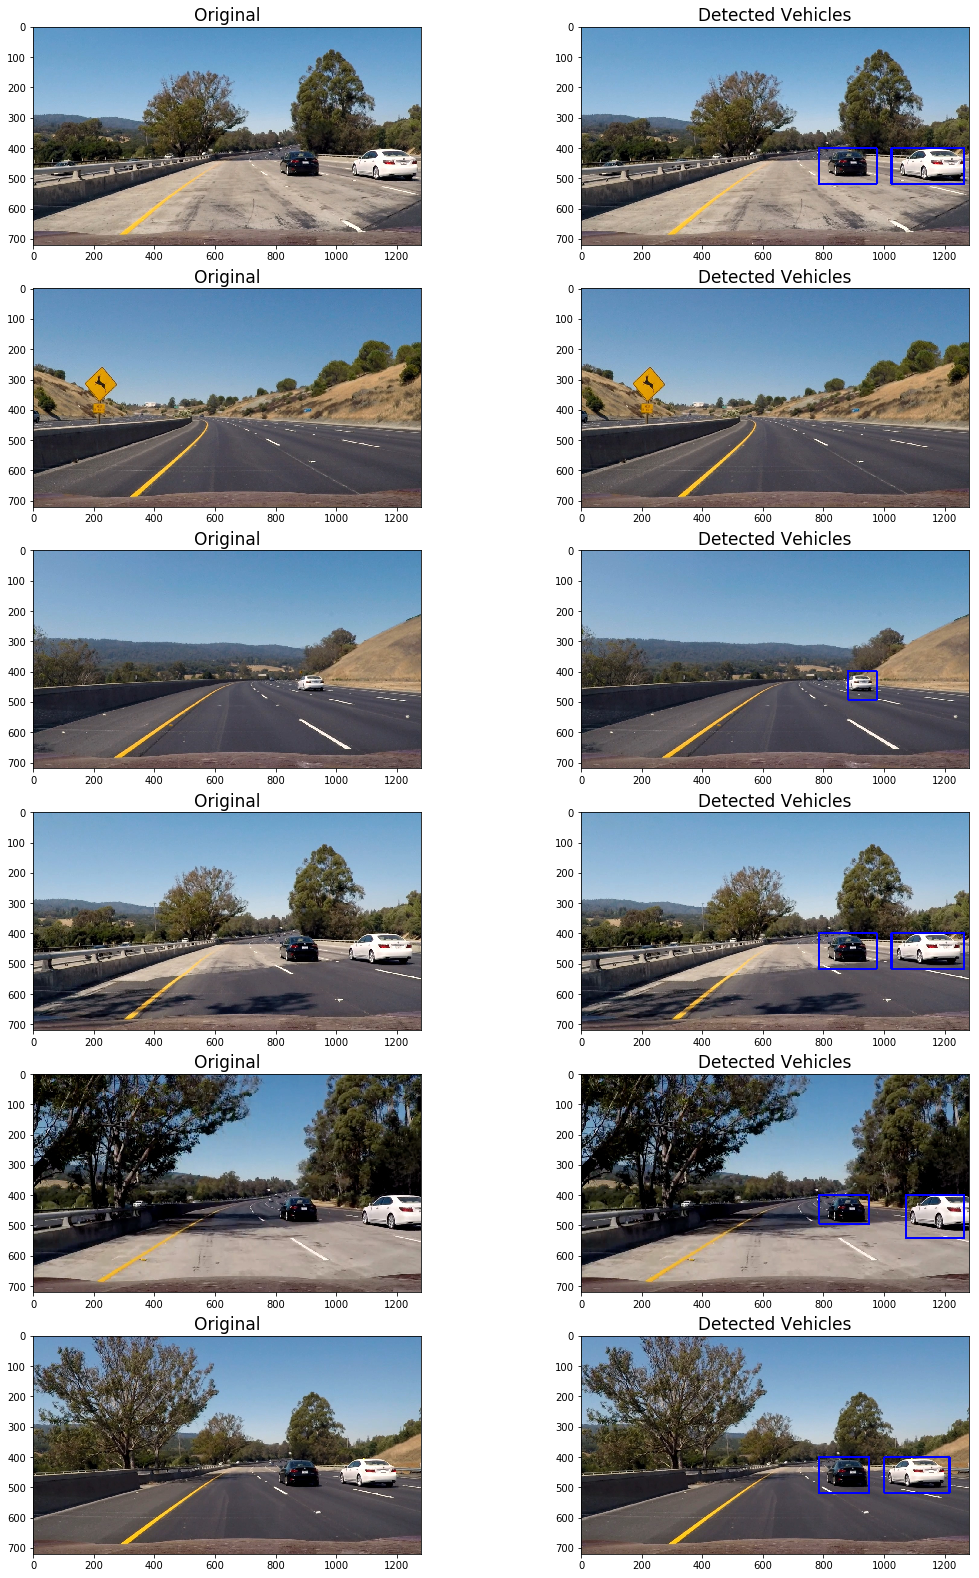

In [23]:
out_images = [single_pipeline(img) for img in test_images]
display_images(merge_lists(test_images, out_images),
              titles=["Original", "Detected Vehicles"]*len(out_images))

## VI. Detection on Videos ##

`Cell 30`

In [40]:
def video_pipeline(img):
    
    global heatstack
    
    copyimg = np.copy(img)
    
    xstart = 400
    ystart = 400
    ystop = 650
    scale = 1.5
    
    # Find regions where cars are detected
    bboxes = find_cars(copyimg, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Create a blank heatmap for the current frame
    heatmap = np.zeros_like(img[:,:,0])
    
    # On first run, fill up the heatstack to avoid false positives
    if(len(heatstack)==0):
        for i in range(20):
            heatstack.append(heatmap)
    
    # Update heatmap based on detected car locations
    heatmap = add_heat(heatmap, bboxes)

    
    # Add it to the heatstack
    heatstack.append(heatmap)
    
    # Get the mean of the heatstack
    meanstack = np.mean(heatstack, axis=0).astype(np.int32)

    
    
    # Apply labels to detect individual vehicles
    labels = label(meanstack)
    final_img = draw_labeled_bboxes(copyimg, labels)
    
    return final_img

`Cell 31`

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

if not os.path.isdir("test_videos_output"):
    os.mkdir("test_videos_output")

`Cell 32`

In [48]:
global heatstack
heatstack = deque(maxlen=20)

v1_output = "test_videos_output/project_video_output.mp4"
project_video = VideoFileClip("project_video.mp4")
clip = project_video.fl_image(video_pipeline)
%time clip.write_videofile(v1_output, audio=False)

clip.reader.close()
clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:06:16<00:03,  3.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 1h 6min 19s


`Cell 33`

In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(v1_output))

## VII. Visualization ##

In [86]:
# HOG Features
img = cv2.cvtColor(cars[5], cv2.COLOR_RGB2YCrCb)
xt, img_hog = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

img_n = cv2.cvtColor(noncars[104], cv2.COLOR_RGB2YCrCb)
xt_n, img_hog_n = get_hog_features(img_n[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

img_2 = cv2.cvtColor(cars[2045], cv2.COLOR_RGB2YCrCb)
xt_2, img_hog_2 = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

img_n2 = cv2.cvtColor(noncars[2723], cv2.COLOR_RGB2YCrCb)
xt_n_2, img_hog_n_2 = get_hog_features(img_n[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False) 

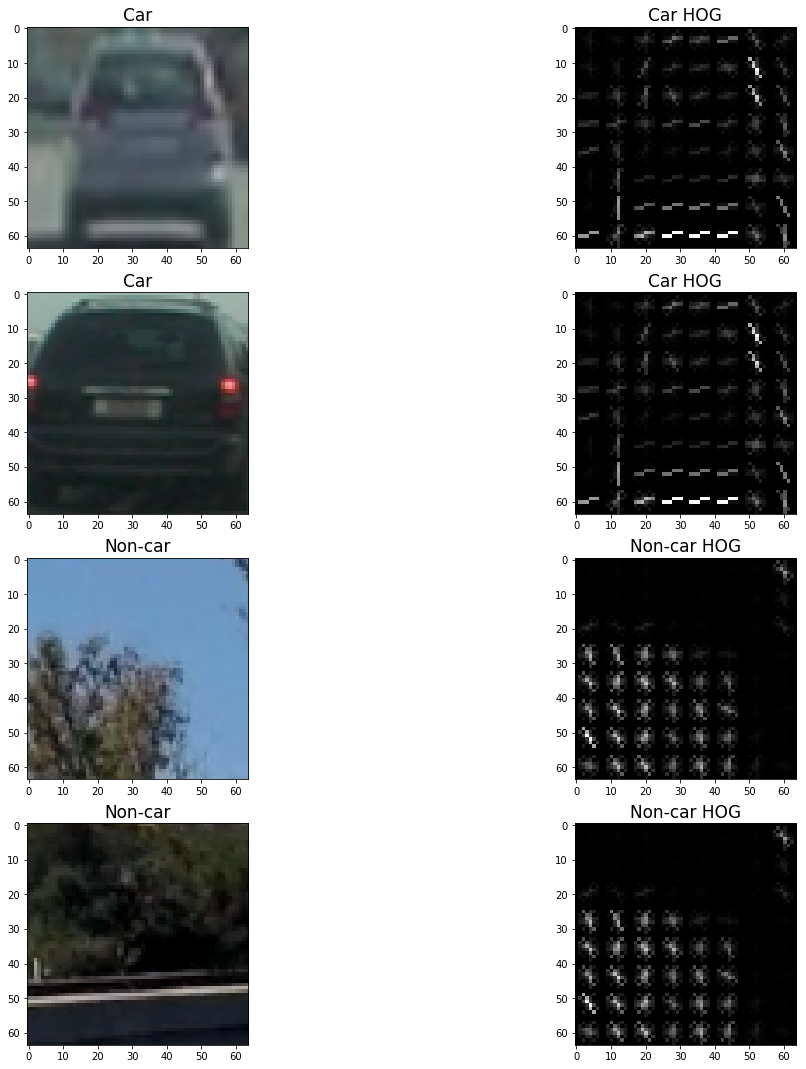

In [87]:
# Compare HOG features of random car and non-car images

display_images(merge_lists([cars[5], cars[2045], noncars[104], noncars[2723]],
                            [img_hog, img_hog_2, img_hog_n, img_hog_n_2]),
               titles = ["Car", "Car HOG", "Car", "Car HOG", "Non-car", "Non-car HOG", "Non-car", "Non-car HOG"],
                         cmap='gray')

In [101]:
# Heat Map

t_img = test_images[0]

xstart = 400
ystart = 400
ystop = 650
scale = 1.5

car_boxes = [find_cars(img,  xstart, ystart, ystop,
                      scale, svc, X_scaler, orient,
                      pix_per_cell, cell_per_block,
                      spatial_size, hist_bins) for img in test_images]

# Create a blank heatmap for the current frame
heatmaps = [np.zeros_like(t_img[:,:,0]) for i in range(len(test_images))]
out = []
for i in range(len(test_images)):
    heatmap = add_heat(heatmaps[i], car_boxes[i])
    out.append(heatmap)


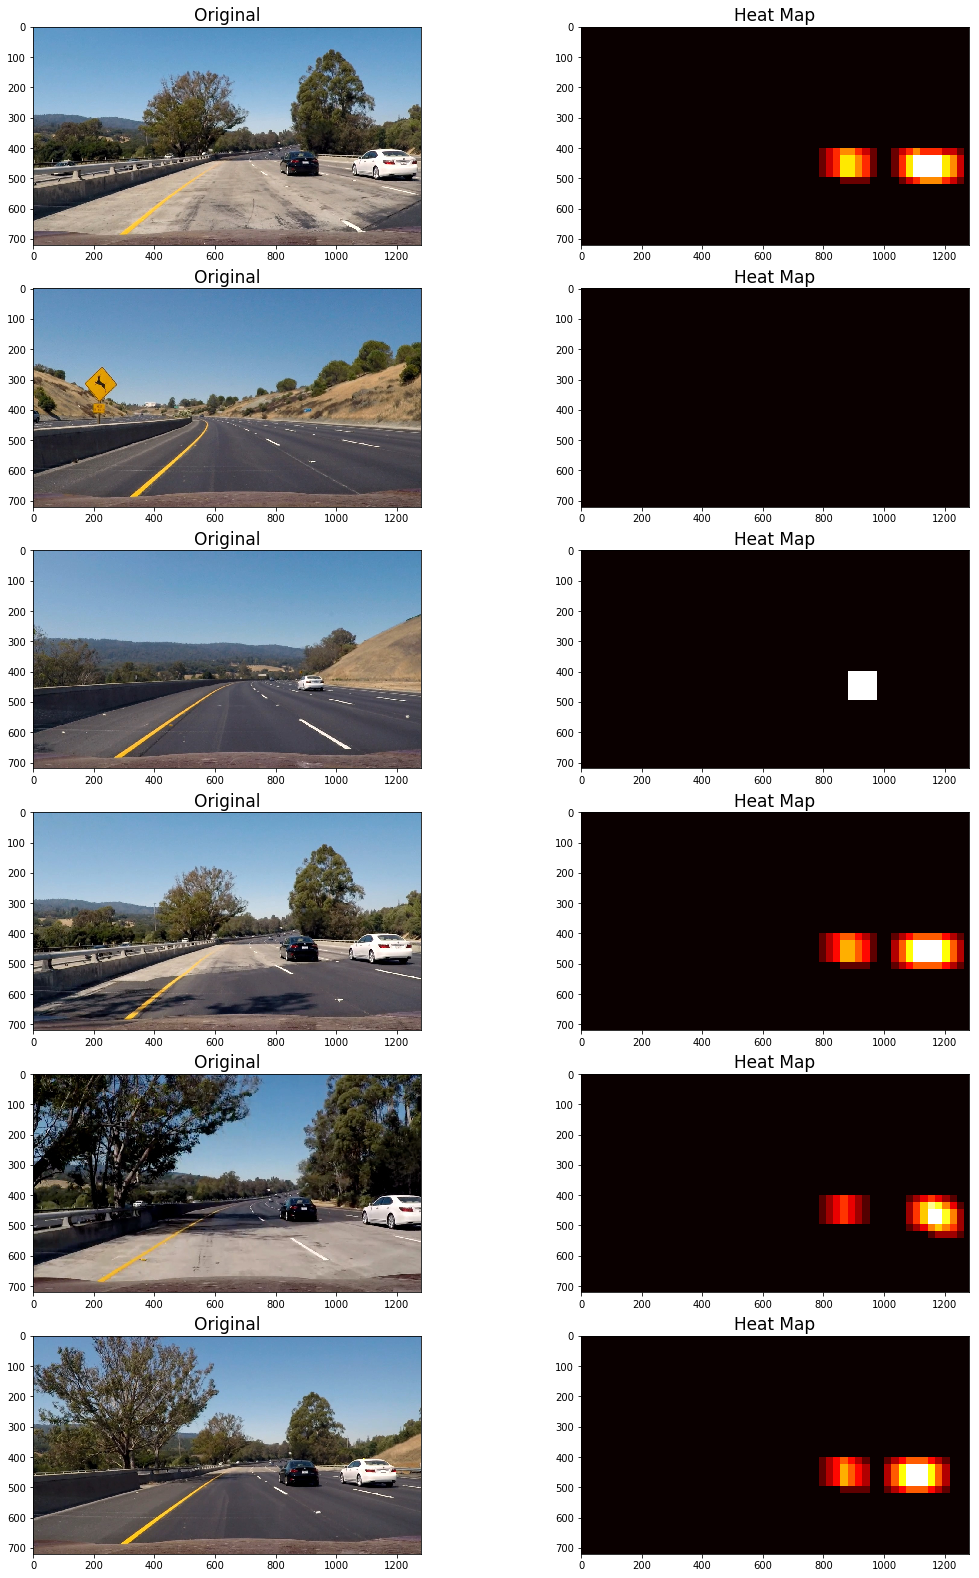

In [102]:
display_images(merge_lists(test_images, out),
               titles=['Original', 'Heat Map']*6,
               cmap='hot')



In [108]:
label_imgs = []
for i in range(len(out)):
    i = label(out[i])
    label_imgs.append(i[0])

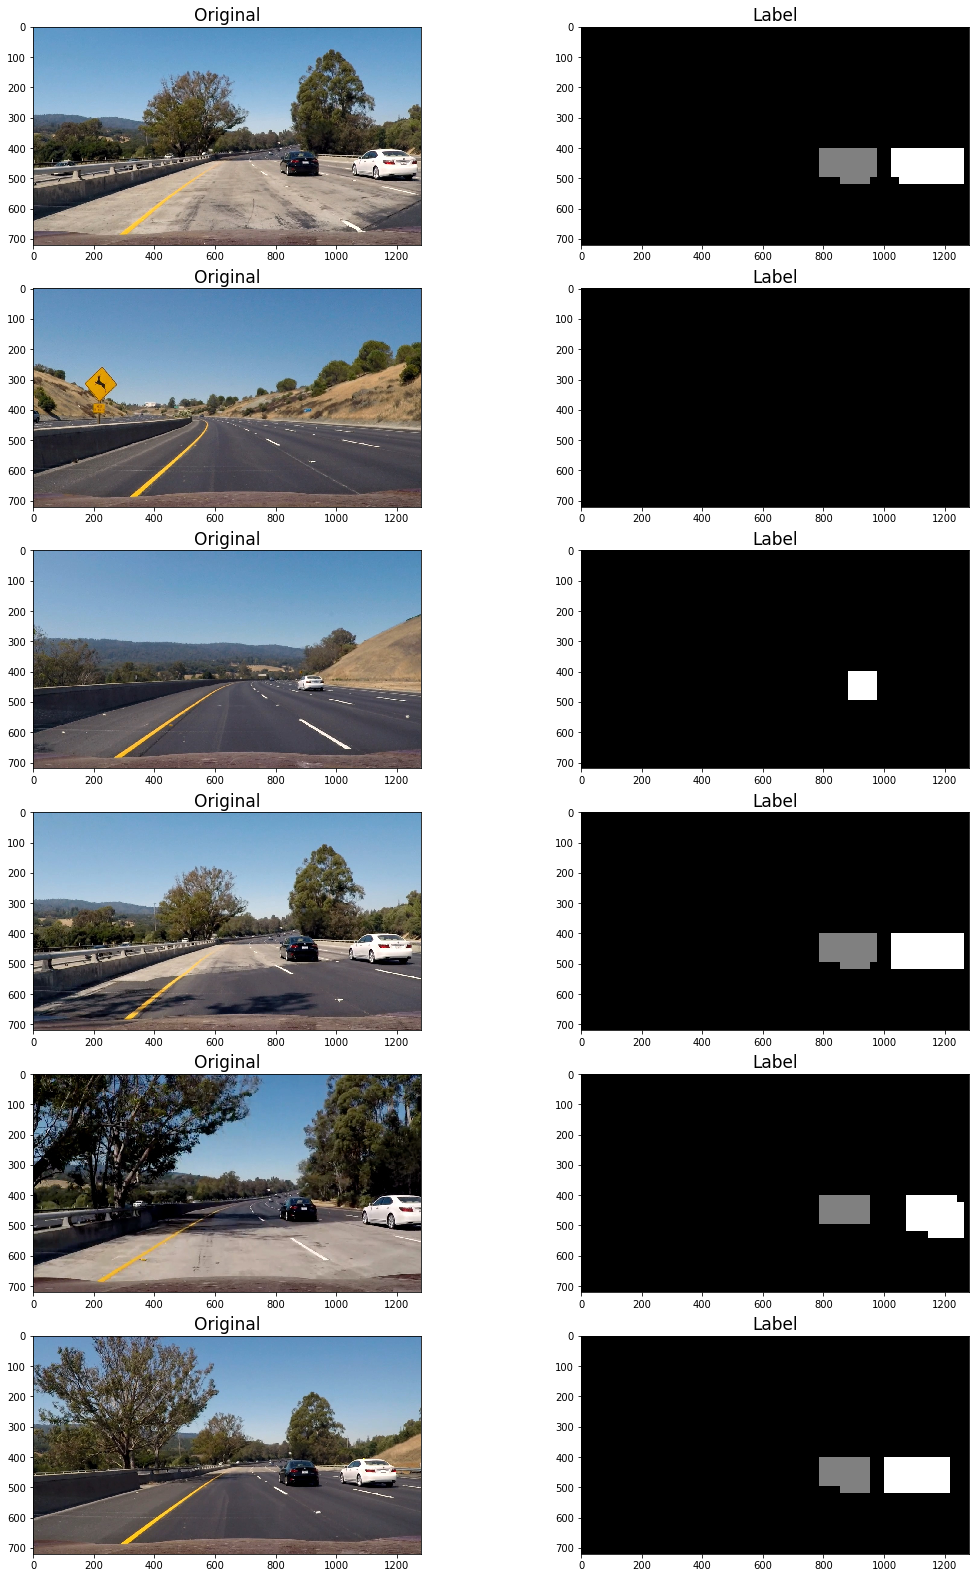

In [110]:
display_images(merge_lists(test_images, label_imgs),
               titles=['Original', 'Label']*6, cmap='gray')
